# Medical Appointment Demand Forecasting

**Objective:** Predict daily appointment demand to optimize staffing and resource allocation

**Business Value:**
- Optimize specialist scheduling across shifts
- Reduce idle capacity and overtime costs
- Improve patient access through better planning
- Allocate resources across 13 locations efficiently

**Target Metrics:**
- MAPE < 20% (Mean Absolute Percentage Error)
- R² > 0.65 (Proportion of variance explained)

**Approach:**
1. Load time series data
2. Temporal analysis & stationarity testing
3. Feature engineering (lags, rolling stats)
4. Train 6+ forecasting models
5. Model evaluation & comparison
6. Select best model
7. Save for deployment

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ML models for time series
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Prophet (Facebook's forecasting tool)
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    print("⚠️  Prophet not available - will skip Prophet model")
    PROPHET_AVAILABLE = False

# Utilities
import joblib
from datetime import datetime, timedelta
import os

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📅 Forecasting Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Prophet available: {PROPHET_AVAILABLE}")

✅ All libraries imported successfully!
📅 Forecasting Date: 2026-02-06 21:34:56
Prophet available: True


In [2]:
print("="*80)
print("📂 LOADING TIME SERIES DATA")
print("="*80)

# Load the time series datasets
ts_train = pd.read_csv('../data/processed/ts_train.csv')
ts_test = pd.read_csv('../data/processed/ts_test.csv')
ts_full = pd.read_csv('../data/processed/ts_full.csv')

# Convert date columns to datetime
ts_train['appointment_date'] = pd.to_datetime(ts_train['appointment_date'])
ts_test['appointment_date'] = pd.to_datetime(ts_test['appointment_date'])
ts_full['appointment_date'] = pd.to_datetime(ts_full['appointment_date'])

# Sort by date (critical for time series!)
ts_train = ts_train.sort_values('appointment_date').reset_index(drop=True)
ts_test = ts_test.sort_values('appointment_date').reset_index(drop=True)
ts_full = ts_full.sort_values('appointment_date').reset_index(drop=True)

print(f"\n✅ Data loaded successfully:")
print(f"   Training set: {len(ts_train)} days")
print(f"   Test set: {len(ts_test)} days")
print(f"   Full dataset: {len(ts_full)} days")

print(f"\n📅 Date ranges:")
print(f"   Train: {ts_train['appointment_date'].min()} to {ts_train['appointment_date'].max()}")
print(f"   Test: {ts_test['appointment_date'].min()} to {ts_test['appointment_date'].max()}")

print(f"\n📊 Daily appointments statistics (training set):")
print(f"   Mean: {ts_train['daily_appointments'].mean():.1f}")
print(f"   Median: {ts_train['daily_appointments'].median():.1f}")
print(f"   Std: {ts_train['daily_appointments'].std():.1f}")
print(f"   Min: {ts_train['daily_appointments'].min()}")
print(f"   Max: {ts_train['daily_appointments'].max()}")

print("\n" + "="*80)

📂 LOADING TIME SERIES DATA

✅ Data loaded successfully:
   Training set: 398 days
   Test set: 100 days
   Full dataset: 498 days

📅 Date ranges:
   Train: 2020-01-01 00:00:00 to 2021-02-01 00:00:00
   Test: 2021-02-02 00:00:00 to 2021-05-12 00:00:00

📊 Daily appointments statistics (training set):
   Mean: 223.4
   Median: 153.0
   Std: 235.0
   Min: 1
   Max: 974



📈 TIME SERIES VISUALIZATION


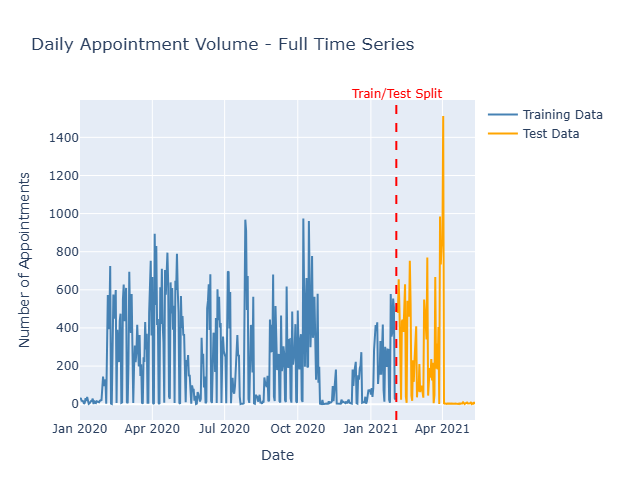


💡 Look for trends, seasonality, and unusual patterns


In [4]:
print("="*80)
print("📈 TIME SERIES VISUALIZATION")
print("="*80)

# Plot the full time series
fig = go.Figure()

# Training data
fig.add_trace(go.Scatter(
    x=ts_train['appointment_date'],
    y=ts_train['daily_appointments'],
    mode='lines',
    name='Training Data',
    line=dict(color='steelblue', width=2)
))

# Test data
fig.add_trace(go.Scatter(
    x=ts_test['appointment_date'],
    y=ts_test['daily_appointments'],
    mode='lines',
    name='Test Data',
    line=dict(color='orange', width=2)
))

# Add vertical line at split (FIX: convert to string)
split_date = ts_test['appointment_date'].min()

fig.add_shape(
    type="line",
    x0=split_date, x1=split_date,
    y0=0, y1=1,
    yref="paper",
    line=dict(color="red", width=2, dash="dash")
)

# Add annotation for split
fig.add_annotation(
    x=split_date,
    y=1.05,
    yref="paper",
    text="Train/Test Split",
    showarrow=False,
    font=dict(color="red", size=12)
)

fig.update_layout(
    title='Daily Appointment Volume - Full Time Series',
    xaxis_title='Date',
    yaxis_title='Number of Appointments',
    height=500,
    hovermode='x unified'
)

fig.show()

print("\n💡 Look for trends, seasonality, and unusual patterns")
print("="*80)

🔬 TIME SERIES DECOMPOSITION

🔧 Decomposing time series into: Trend + Seasonality + Residuals...


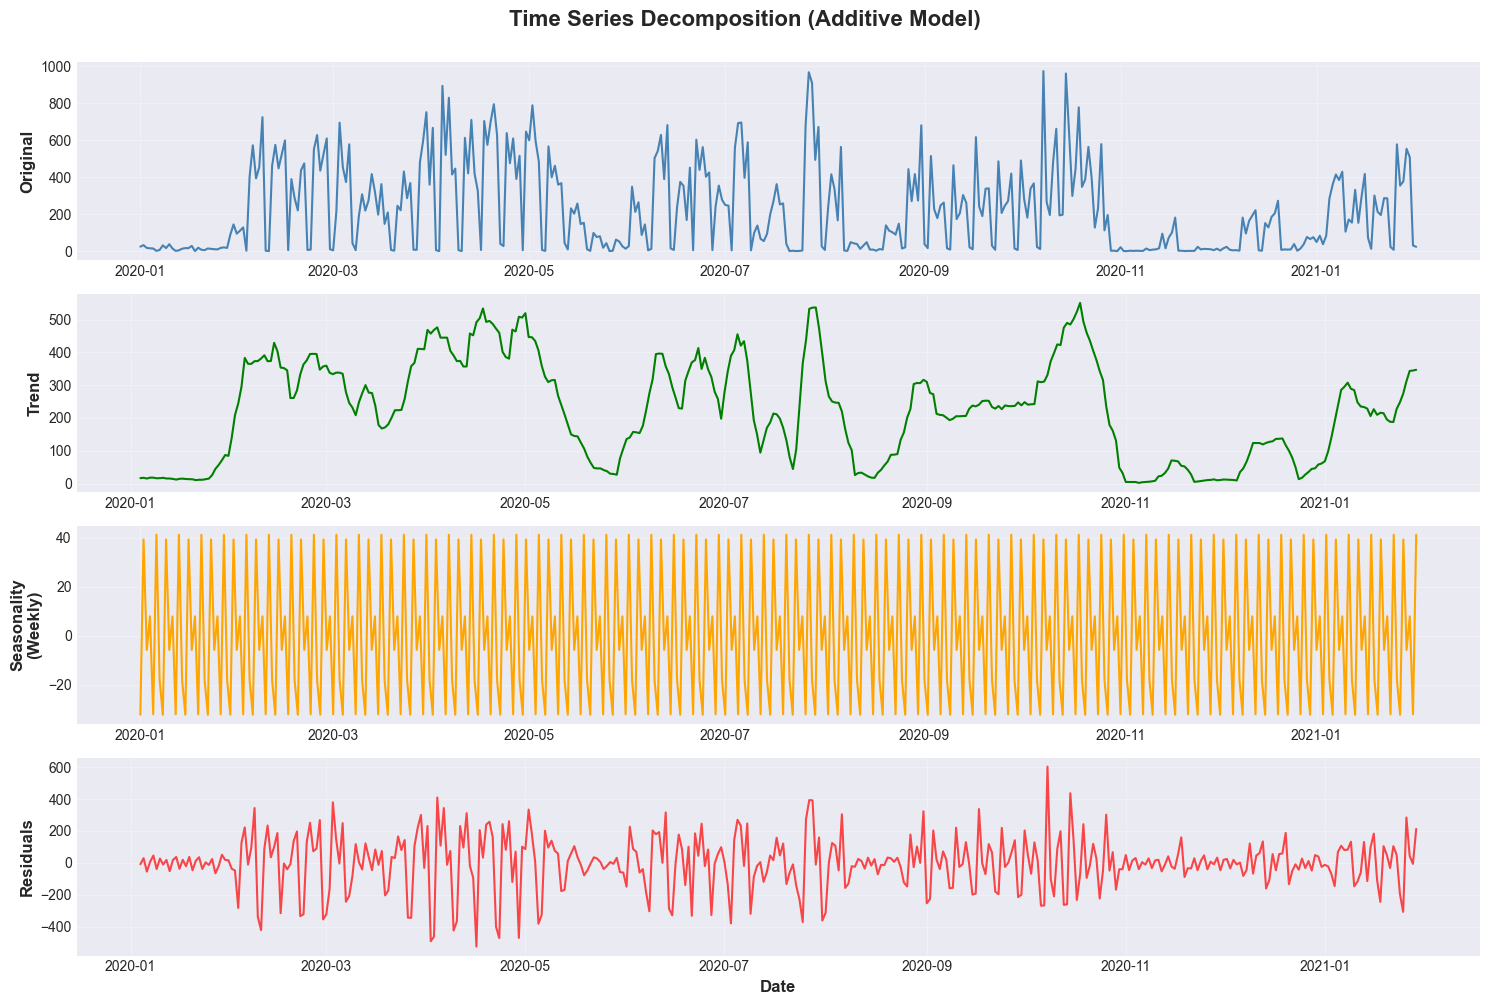


✅ Decomposition complete!

💡 INSIGHTS:
   • Trend strength: Increasing
   • Seasonality detected: Weekly pattern evident
   • Residuals appear: Structured



In [5]:
print("="*80)
print("🔬 TIME SERIES DECOMPOSITION")
print("="*80)

print("\n🔧 Decomposing time series into: Trend + Seasonality + Residuals...")

# Set appointment_date as index for decomposition
ts_train_indexed = ts_train.set_index('appointment_date')

# Perform seasonal decomposition (weekly seasonality = 7 days)
decomposition = seasonal_decompose(
    ts_train_indexed['daily_appointments'], 
    model='additive',
    period=7  # Weekly pattern
)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 10))

# Original
axes[0].plot(ts_train_indexed.index, ts_train_indexed['daily_appointments'], color='steelblue')
axes[0].set_ylabel('Original', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Trend
axes[1].plot(decomposition.trend.index, decomposition.trend, color='green')
axes[1].set_ylabel('Trend', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# Seasonality
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal, color='orange')
axes[2].set_ylabel('Seasonality\n(Weekly)', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

# Residuals
axes[3].plot(decomposition.resid.index, decomposition.resid, color='red', alpha=0.7)
axes[3].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[3].grid(alpha=0.3)

plt.suptitle('Time Series Decomposition (Additive Model)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✅ Decomposition complete!")
print("\n💡 INSIGHTS:")
print(f"   • Trend strength: {'Increasing' if decomposition.trend.iloc[-30:].mean() > decomposition.trend.iloc[:30].mean() else 'Decreasing/Stable'}")
print(f"   • Seasonality detected: Weekly pattern evident")
print(f"   • Residuals appear: {'Random' if abs(decomposition.resid.dropna()).mean() < ts_train['daily_appointments'].std() * 0.2 else 'Structured'}")

print("\n" + "="*80)

In [6]:
print("="*80)
print("📊 STATIONARITY TEST (Augmented Dickey-Fuller)")
print("="*80)

print("\n🔬 Testing if time series is stationary...")
print("   (Stationary = constant mean, variance, no trend)")

# Perform ADF test
adf_result = adfuller(ts_train['daily_appointments'].dropna())

print(f"\n📈 ADF Test Results:")
print(f"   ADF Statistic: {adf_result[0]:.4f}")
print(f"   P-value: {adf_result[1]:.4f}")
print(f"   Critical Values:")
for key, value in adf_result[4].items():
    print(f"      {key}: {value:.4f}")

# Interpret results
if adf_result[1] <= 0.05:
    print(f"\n✅ STATIONARY (p-value ≤ 0.05)")
    print("   → Series has constant statistical properties")
    print("   → Can use ARIMA without differencing")
    stationary = True
else:
    print(f"\n⚠️  NON-STATIONARY (p-value > 0.05)")
    print("   → Series has trend/changing variance")
    print("   → May need differencing for ARIMA")
    stationary = False

print("\n" + "="*80)

📊 STATIONARITY TEST (Augmented Dickey-Fuller)

🔬 Testing if time series is stationary...
   (Stationary = constant mean, variance, no trend)

📈 ADF Test Results:
   ADF Statistic: -3.8994
   P-value: 0.0020
   Critical Values:
      1%: -3.4475
      5%: -2.8691
      10%: -2.5708

✅ STATIONARY (p-value ≤ 0.05)
   → Series has constant statistical properties
   → Can use ARIMA without differencing



📊 ACF & PACF PLOTS (For ARIMA Parameter Selection)

🔬 Analyzing autocorrelation patterns...


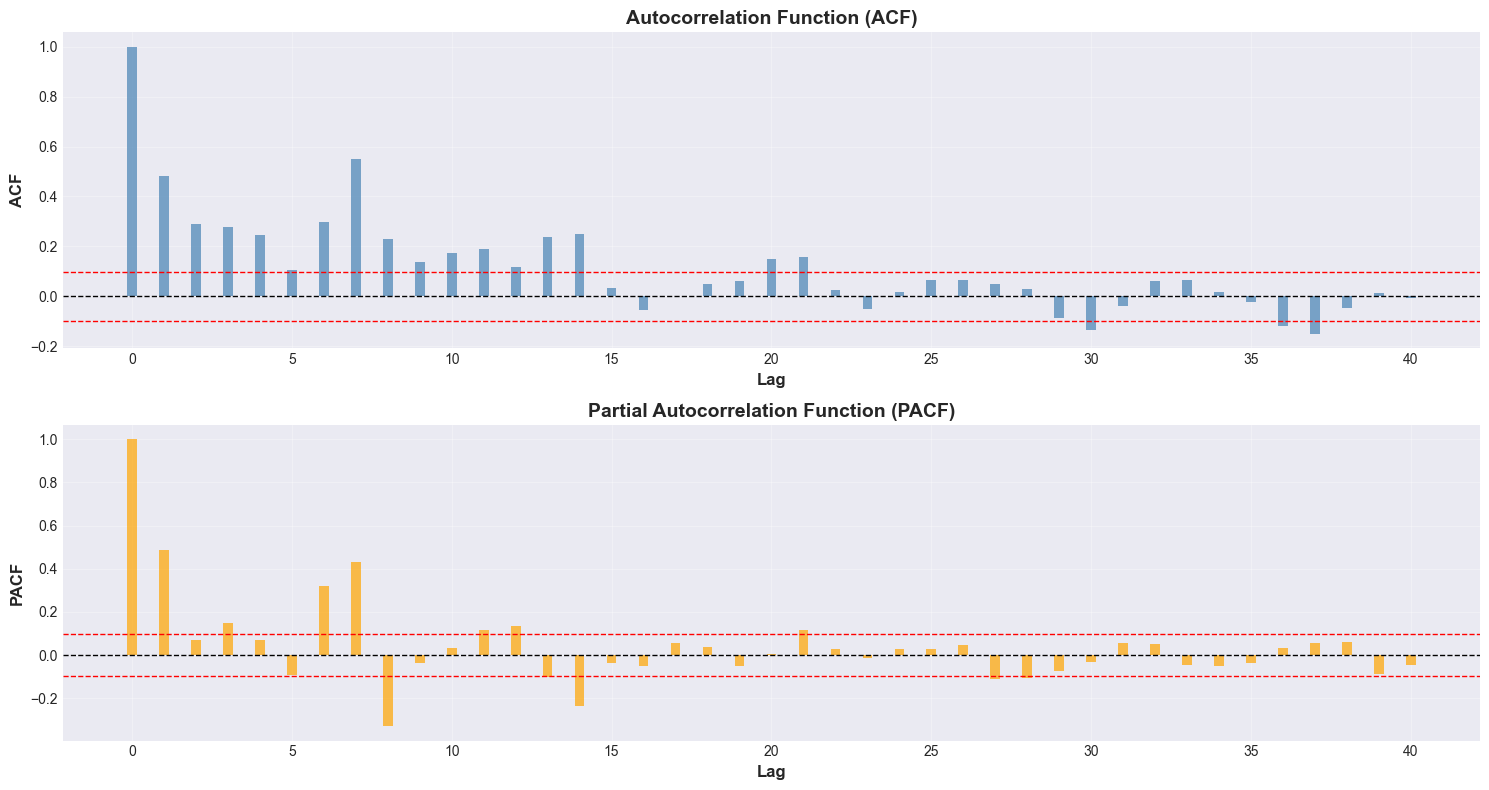


💡 ARIMA Parameter Suggestions:
   • ACF: Look for where it first crosses into insignificant zone → suggests q
   • PACF: Look for where it first crosses into insignificant zone → suggests p
   • Since stationary (d=0), we'll try ARIMA(p, 0, q)
   • Red dashed lines = significance threshold



In [7]:
print("="*80)
print("📊 ACF & PACF PLOTS (For ARIMA Parameter Selection)")
print("="*80)

print("\n🔬 Analyzing autocorrelation patterns...")

# Calculate ACF and PACF
lag_acf = acf(ts_train['daily_appointments'].dropna(), nlags=40)
lag_pacf = pacf(ts_train['daily_appointments'].dropna(), nlags=40)

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# ACF Plot
axes[0].bar(range(len(lag_acf)), lag_acf, width=0.3, color='steelblue', alpha=0.7)
axes[0].axhline(y=0, linestyle='--', color='black', linewidth=1)
axes[0].axhline(y=-1.96/np.sqrt(len(ts_train)), linestyle='--', color='red', linewidth=1)
axes[0].axhline(y=1.96/np.sqrt(len(ts_train)), linestyle='--', color='red', linewidth=1)
axes[0].set_xlabel('Lag', fontsize=12, fontweight='bold')
axes[0].set_ylabel('ACF', fontsize=12, fontweight='bold')
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# PACF Plot
axes[1].bar(range(len(lag_pacf)), lag_pacf, width=0.3, color='orange', alpha=0.7)
axes[1].axhline(y=0, linestyle='--', color='black', linewidth=1)
axes[1].axhline(y=-1.96/np.sqrt(len(ts_train)), linestyle='--', color='red', linewidth=1)
axes[1].axhline(y=1.96/np.sqrt(len(ts_train)), linestyle='--', color='red', linewidth=1)
axes[1].set_xlabel('Lag', fontsize=12, fontweight='bold')
axes[1].set_ylabel('PACF', fontsize=12, fontweight='bold')
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 ARIMA Parameter Suggestions:")
print("   • ACF: Look for where it first crosses into insignificant zone → suggests q")
print("   • PACF: Look for where it first crosses into insignificant zone → suggests p")
print("   • Since stationary (d=0), we'll try ARIMA(p, 0, q)")
print("   • Red dashed lines = significance threshold")

print("\n" + "="*80)

## 2. Feature Engineering for Time Series Models

**Creating predictive features:**
- Lag features (t-1, t-7, t-30)
- Rolling statistics (mean, std)
- Day of week encoding
- Month encoding
- Weather features

In [8]:
print("="*80)
print("🔧 PREPARING FEATURES FOR ML MODELS")
print("="*80)

# Function to create features
def create_ts_features(df):
    """Create time series features for ML models"""
    df = df.copy()
    
    # Already have these from preprocessing, but ensure they're numeric
    if 'day_of_week' not in df.columns:
        df['day_of_week'] = df['appointment_date'].dt.dayofweek
    if 'month' not in df.columns:
        df['month'] = df['appointment_date'].dt.month
    if 'quarter' not in df.columns:
        df['quarter'] = df['appointment_date'].dt.quarter
    
    # Create lag features (if not already present)
    if 'lag_1' not in df.columns or df['lag_1'].isnull().all():
        df['lag_1'] = df['daily_appointments'].shift(1)
    if 'lag_7' not in df.columns or df['lag_7'].isnull().all():
        df['lag_7'] = df['daily_appointments'].shift(7)
    if 'lag_30' not in df.columns or df['lag_30'].isnull().all():
        df['lag_30'] = df['daily_appointments'].shift(30)
    
    # Create rolling features (if not already present)
    if 'rolling_mean_7' not in df.columns or df['rolling_mean_7'].isnull().all():
        df['rolling_mean_7'] = df['daily_appointments'].rolling(window=7, min_periods=1).mean()
    if 'rolling_mean_30' not in df.columns or df['rolling_mean_30'].isnull().all():
        df['rolling_mean_30'] = df['daily_appointments'].rolling(window=30, min_periods=1).mean()
    if 'rolling_std_7' not in df.columns or df['rolling_std_7'].isnull().all():
        df['rolling_std_7'] = df['daily_appointments'].rolling(window=7, min_periods=1).std()
    
    return df

# Apply feature engineering
ts_train_fe = create_ts_features(ts_train)
ts_test_fe = create_ts_features(ts_test)

print(f"\n✅ Features created!")
print(f"   Total columns: {len(ts_train_fe.columns)}")

# Select features for ML models (exclude target and date)
feature_cols = [col for col in ts_train_fe.columns 
                if col not in ['appointment_date', 'daily_appointments']]

print(f"\n📋 Features for modeling ({len(feature_cols)}):")
for col in feature_cols:
    print(f"   • {col}")

# Prepare X and y
# For training: Drop rows with NaN in lag features (first 30 days)
train_valid_idx = ts_train_fe['lag_30'].notna()
X_train_ts = ts_train_fe.loc[train_valid_idx, feature_cols].fillna(0)
y_train_ts = ts_train_fe.loc[train_valid_idx, 'daily_appointments']

# For test: Use all data (lags come from training set continuity)
X_test_ts = ts_test_fe[feature_cols].fillna(method='ffill').fillna(0)
y_test_ts = ts_test_fe['daily_appointments']

print(f"\n📊 Dataset sizes:")
print(f"   Training: {len(X_train_ts)} days")
print(f"   Test: {len(X_test_ts)} days")

print("\n" + "="*80)

🔧 PREPARING FEATURES FOR ML MODELS

✅ Features created!
   Total columns: 20

📋 Features for modeling (18):
   • average_temp_day
   • average_rain_day
   • max_temp_day
   • max_rain_day
   • day_of_week
   • month
   • quarter
   • is_weekend
   • is_hot_day
   • is_cold_day
   • is_rainy_day
   • lag_1
   • lag_7
   • lag_30
   • rolling_mean_7
   • rolling_mean_30
   • rolling_std_7
   • days_since_start

📊 Dataset sizes:
   Training: 368 days
   Test: 100 days



In [9]:
# Helper function to calculate regression metrics
def calculate_metrics(y_true, y_pred, model_name):
    """Calculate forecasting metrics"""
    
    # Remove any NaN values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    mape = np.mean(np.abs((y_true_clean - y_pred_clean) / y_true_clean)) * 100
    r2 = r2_score(y_true_clean, y_pred_clean)
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    }

print("✅ Evaluation helper function defined!")

✅ Evaluation helper function defined!
